<a href="https://colab.research.google.com/github/Aryaman2912/ML/blob/master/Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary packages and modules
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
import itertools

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Fetch CIFAR10 dataset
from keras.datasets import cifar10
(train_X,train_y),(test_X,test_y) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
classes= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size=0.04,random_state=42)
# Training is done on a truncated dataset cuz the entire dataset takes too much ram when the images are resized(can be fixed hopefully).
train_X,train_y = train_X[:15000],train_y[:15000]

In [5]:
# Data preprocessing

# Resize images to 227x227 as that is the input needed for Alexnet architecture
def process_images(image, label):
  image = tf.image.per_image_standardization(image)
  image = tf.image.resize(image,(227,227))
  return image,label

train_ds = tf.data.Dataset.from_tensor_slices((train_X,train_y))
test_ds = tf.data.Dataset.from_tensor_slices((test_X,test_y))
val_ds = tf.data.Dataset.from_tensor_slices((val_X,val_y))

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=64,drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=test_ds_size)
                  .batch(batch_size=64,drop_remainder=True))
val_ds = (val_ds
                  .map(process_images)
                  .shuffle(buffer_size=val_ds_size)
                  .batch(batch_size=64,drop_remainder=True))

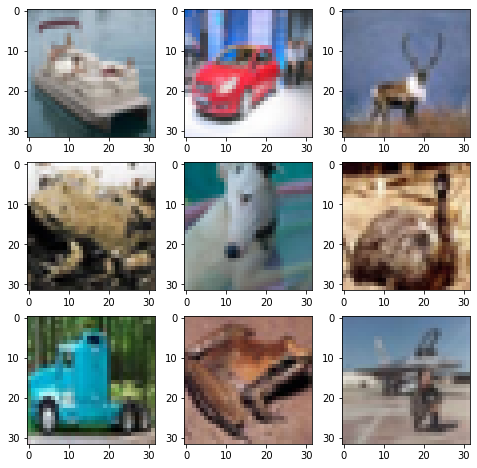

(15000, 32, 32, 3)


In [6]:
plt.figure(figsize=(8,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(train_X[i])
plt.show()

print(train_X.shape)

In [7]:
# The model below contains the Alexnet architecture

model = tf.keras.Sequential([
    # CNN 1 followed by Batch normalization and Max pooling layers                         
    keras.layers.Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), activation = 'relu', input_shape = (227,227,3), padding = 'valid'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid'),

    # CNN 2 followed by Batch normalization and max pooling layers
    keras.layers.Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid'),

    # CNN 3 followed by batch normalization
    keras.layers.Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'),
    keras.layers.BatchNormalization(),

    # CNN 4 followed by batch normalization
    keras.layers.Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'),
    keras.layers.BatchNormalization(),

    # CNN 5 followed by batch normalization and max pooling layers
    keras.layers.Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size = (3,3), strides = (2,2)),

    # Flatten the output of the CNN to one dimension
    keras.layers.Flatten(),

    # fully connected layer 1 with dropout and batch normalization layers
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),

    # fully connected layer 2 with dropout and batch normalization layers
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),

    # fully connected layer 3 with softmax output
    keras.layers.Dense(10, activation = 'softmax')
])

In [8]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [9]:
history = model.fit(train_ds,epochs = 30,batch_size=64,validation_data = val_ds,verbose=1)

Epoch 1/30
234/234 [==============================] - 47s 111ms/step - loss: 2.9497 - acc: 0.2745 - val_loss: 2.0372 - val_acc: 0.3710
Epoch 2/30
234/234 [==============================] - 36s 108ms/step - loss: 1.8535 - acc: 0.4130 - val_loss: 2.3369 - val_acc: 0.4299
Epoch 3/30
234/234 [==============================] - 34s 104ms/step - loss: 1.6997 - acc: 0.4683 - val_loss: 1.4362 - val_acc: 0.5207
Epoch 4/30
234/234 [==============================] - 34s 105ms/step - loss: 1.4527 - acc: 0.5260 - val_loss: 1.5439 - val_acc: 0.5222
Epoch 5/30
234/234 [==============================] - 34s 105ms/step - loss: 1.3351 - acc: 0.5639 - val_loss: 1.3454 - val_acc: 0.5680
Epoch 6/30
234/234 [==============================] - 34s 104ms/step - loss: 1.2401 - acc: 0.6038 - val_loss: 1.4344 - val_acc: 0.5640
Epoch 7/30
234/234 [==============================] - 34s 105ms/step - loss: 1.1294 - acc: 0.6310 - val_loss: 1.4817 - val_acc: 0.5504
Epoch 8/30
234/234 [==============================] - 3

In [10]:
score,acc = model.evaluate(test_ds)

156/156 [==============================] - 12s 40ms/step - loss: 1.9901 - acc: 0.6430


In [13]:
print(f"Accuracy on test set is: {acc*100}%")

Accuracy on test set is: 64.30288553237915%


# Reasons for low accuracy on test set?


1.   The Alexnet architecture needs 227x227 sized images for training whereas CIFAR10 dataset contains images of size 32x32. Resizing 32x32 to 227x227 might result in loss of features.
2.   The CIFAR10 contains 50000 but I have trained it only on 15000 images(Colab crashes beyond this).
3.   Overfitting



